# Community Detection Example

This notebook is adapted from Damhán's `csv_to_nx_graph.py`

Now it makes the final graph prettier and can load 2016 data

## Load modules

In [1]:
import pandas as pd
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.lines import Line2D
import textwrap
from pprint import pprint

## Some functions

In [2]:
def graph_of_data(df):
    """
    Input: an election dataframe for a constitutency.
    Output: a NetworkX weighted digraph representing the transfers between candidates.
    Does this by filtering the inputted dataframe by count, then extracting the values of transfers using Pandas.

    """
    
#     #--Merge these columns, will be labels of the nodes
#     df["Name"] = (
#     df["Candidate surname"]
#     + " "
#     + df["Candidate First Name"].str[0].str.upper()
#     + " "
#     + df["Party Id"]
#     )
    
    #--Create the DiGraph
    G = nx.DiGraph()
    count_lst = list(df["Count Number"].unique())
    #--There are no transfers on the first count so we will ignore
    count_lst.remove(1)
    #--Filter by count
    for count in count_lst:
        count_df = df[df["Count Number"]==count]
        #--filter by candidates whose votes are transferred
        src_cands = count_df[count_df["Transfers"]<0]
        #--filter by candidates who receive these transfers
        to_cands =count_df[count_df["Transfers"]>0]
        #--get these list of candidates to create the graph below
        src_names = list(src_cands["Unique Candidate Id"].values)
        to_names = list(to_cands["Unique Candidate Id"].values)

        #--add edge weights as: the amount of votes transferred to a candidate as a proportion of the total votes transferred per count
        src_wgts = list(src_cands["Transfers"].values)
        to_wgts = list(to_cands["Transfers"].values)

            #--if there's more than one src_cand per count, the number of transfers a candidate receives will be
            #--a proportion of this total
        total = np.abs(np.sum(src_wgts))

        wgts = [round(wgt/total, 2) for wgt in to_wgts]
            
        #--Create a weighted edge between each source candidate and each target candidate
        for i in range(len(src_names)):
            for j in range(len(to_names)):
                G.add_edge(src_names[i],to_names[j],weight=wgts[j])
    return G

In [3]:
def plot_G(G, layout="circular"):
    """
    Input: a NetworkX weighted DiGraph.
    Each edge in the graph has a 'weight' attribute created in above function, that is used by NetworkX default method get_edge_attributes().
    Output: a circular graph, labelled with transfers between candidates.
    
    """
    
    plt.figure(figsize=(12, 12))
    
    opts = {"with_labels":True,"node_size":600}
    
    if (layout=="circular"):
        nx.draw_circular(G,**opts)
    else:
        nx.draw(G,**opts)
    edge_labels = nx.get_edge_attributes(G, "weight")
    nx.draw_networkx_edge_labels(G, pos=nx.circular_layout(G), edge_labels=edge_labels)
    
    plt.title("Graph of Transfers between Candidates")
    plt.show()

In [4]:
def wrap_label(s, width=10):
    # Wrap at word boundaries; join with newline
    return "\n".join(textwrap.wrap(s, width=width, break_long_words=False))

## Load data

In [5]:
full_df = pd.read_csv("2020-05-27_general-election-2020-countdetails-csv_en.csv", encoding="latin-1")
cand_details_df = pd.read_csv("2020-05-27_general-election-2020-candidate_details-csv_en.csv", encoding="Latin-1")
Year = 2020

In [6]:
# full_df = pd.read_csv("generalelection2016countdetails.csv", encoding="Latin-1")
# cand_details_df = pd.read_csv("generalelection2016candidatedetails.csv",encoding="Latin-1")
# Year=2016 # used for plots

In [7]:
full_df

,Constituency Name,Candidate surname,Candidate First Name,Result,Count Number,Non-Transferable,Occurred On Count,Required To Reach Quota,Required To Save Deposit,Transfers,Votes,Total Votes,Constituency Number,Candidate Id
0,Carlow-Kilkenny,AYLWARD,BOBBY,NaN,1,0,0,4724,0,0,7550,7550,1,161
1,Carlow-Kilkenny,AYLWARD,BOBBY,NaN,2,0,0,4483,0,241,7550,7791,1,161
2,Carlow-Kilkenny,AYLWARD,BOBBY,NaN,3,0,0,4354,0,129,7550,7920,1,161
3,Carlow-Kilkenny,AYLWARD,BOBBY,NaN,4,0,0,4150,0,204,7550,8124,1,161
4,Carlow-Kilkenny,AYLWARD,BOBBY,NaN,5,0,0,3866,0,284,7550,8408,1,161
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5010,Wicklow,WHITMORE,JENNIEFER,NaN,11,0,0,739,0,1161,7039,11148,41,203
5011,Wicklow,WHITMORE,JENNIEFER,NaN,12,0,0,482,0,257,7039,11405,41,203
5012,Wicklow,WHITMORE,JENNIEFER,NaN,13,0,0,12,0,470,7039,11875,41,203
5013,Wicklow,WHITMORE,JENNIEFER,Elected,14,0,14,0,0,1530,7039,13405,41,203


## Add unique candidate identifiers

In [8]:
full_df=full_df.copy()
full_df["Unique Candidate Id"]=full_df["Constituency Number"].astype(str)+full_df["Candidate Id"].astype(str)

cand_details_df=cand_details_df.copy()
cand_details_df["Unique Candidate Id"]=cand_details_df["Constituency Number"].astype(str)+cand_details_df["Candidate Id"].astype(str)
#6 digit unique code
cand_details_df["Unique Candidate Id"].str.zfill(6)
# full_df["Unique Candidate Id"]=full_df["Unique Candidate Id"].apply(lambda x:f"{x:02d}")
full_df

,Constituency Name,Candidate surname,Candidate First Name,Result,Count Number,Non-Transferable,Occurred On Count,Required To Reach Quota,Required To Save Deposit,Transfers,Votes,Total Votes,Constituency Number,Candidate Id,Unique Candidate Id
0,Carlow-Kilkenny,AYLWARD,BOBBY,NaN,1,0,0,4724,0,0,7550,7550,1,161,1161
1,Carlow-Kilkenny,AYLWARD,BOBBY,NaN,2,0,0,4483,0,241,7550,7791,1,161,1161
2,Carlow-Kilkenny,AYLWARD,BOBBY,NaN,3,0,0,4354,0,129,7550,7920,1,161,1161
3,Carlow-Kilkenny,AYLWARD,BOBBY,NaN,4,0,0,4150,0,204,7550,8124,1,161,1161
4,Carlow-Kilkenny,AYLWARD,BOBBY,NaN,5,0,0,3866,0,284,7550,8408,1,161,1161
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5010,Wicklow,WHITMORE,JENNIEFER,NaN,11,0,0,739,0,1161,7039,11148,41,203,41203
5011,Wicklow,WHITMORE,JENNIEFER,NaN,12,0,0,482,0,257,7039,11405,41,203,41203
5012,Wicklow,WHITMORE,JENNIEFER,NaN,13,0,0,12,0,470,7039,11875,41,203,41203
5013,Wicklow,WHITMORE,JENNIEFER,Elected,14,0,14,0,0,1530,7039,13405,41,203,41203


## Retrieve Party Abbreviations from CandidateDetailsCSV

In [9]:
#look-up Series with Const number as key and VP as value
lookup = pd.Series(
    cand_details_df["Party Abbreviation"].values,
     index=cand_details_df["Unique Candidate Id"]
)

# XLOOKUP-style mapping
full_df["Party Abbreviation"] = full_df["Unique Candidate Id"].map(lookup)

In [10]:
full_df.sort_values(by="Unique Candidate Id",ascending=True)

,Constituency Name,Candidate surname,Candidate First Name,Result,Count Number,Non-Transferable,Occurred On Count,Required To Reach Quota,Required To Save Deposit,Transfers,Votes,Total Votes,Constituency Number,Candidate Id,Unique Candidate Id,Party Abbreviation
1531,Dublin Central,Brien,Gillian,NaN,1,0,0,5512,797,0,776,776,11,161,11161,S.P.B.P.
1532,Dublin Central,Brien,Gillian,NaN,2,0,0,4698,0,814,776,1590,11,161,11161,S.P.B.P.
1533,Dublin Central,Brien,Gillian,NaN,3,0,0,4664,0,34,776,1624,11,161,11161,S.P.B.P.
1534,Dublin Central,Brien,Gillian,NaN,4,0,0,4463,0,201,776,1825,11,161,11161,S.P.B.P.
1535,Dublin Central,Brien,Gillian,NaN,5,0,0,4452,0,11,776,1836,11,161,11161,S.P.B.P.
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4056,Roscommon - Galway,Tynan,Kenny,NaN,1,0,0,10982,2430,0,422,422,996,171,996171,S.P.B.P.
4057,Roscommon - Galway,Tynan,Kenny,NaN,2,0,0,10962,2410,20,422,442,996,171,996171,S.P.B.P.
4058,Roscommon - Galway,Tynan,Kenny,Excluded,3,0,3,0,2410,-442,422,0,996,171,996171,S.P.B.P.
4059,Roscommon - Galway,Tynan,Kenny,Excluded,4,0,3,0,2410,0,422,0,996,171,996171,S.P.B.P.


In [11]:
constituency_list = sorted(full_df["Constituency Name"].unique())
print(f"There are {len(constituency_list)} constituencies (sp?)")

There are 39 constituencies (sp?)


In [12]:
for k in range(len(constituency_list)):
    print(f"{k:3d} :  {constituency_list[k]:20s}")

  0 :  Carlow-Kilkenny     
  1 :  Cavan-Monaghan      
  2 :  Clare               
  3 :  Cork East           
  4 :  Cork North Central  
  5 :  Cork North West     
  6 :  Cork South Central  
  7 :  Cork South West     
  8 :  Donegal             
  9 :  Dublin Bay North    
 10 :  Dublin Bay South    
 11 :  Dublin Central      
 12 :  Dublin Fingal       
 13 :  Dublin Mid West     
 14 :  Dublin North West   
 15 :  Dublin Rathdown     
 16 :  Dublin South Central
 17 :  Dublin South West   
 18 :  Dublin West         
 19 :  Dun Laoghaire       
 20 :  Galway East         
 21 :  Galway West         
 22 :  Kerry               
 23 :  Kildare North       
 24 :  Kildare South       
 25 :  Laois Offaly        
 26 :  Limerick City       
 27 :  Limerick County     
 28 :  Longford Westmeath  
 29 :  Louth               
 30 :  Mayo                
 31 :  Meath East          
 32 :  Meath West          
 33 :  Roscommon - Galway  
 34 :  Sligo Leitrim       
 35 :  Tipperary    

In [13]:
constituency = constituency_list[21]
constituency_df = full_df.loc[full_df["Constituency Name"]==constituency]
print(constituency)

Galway West


In [14]:
#constituency_df

## Plot an example

### Relabel nodes

#### Original Graph with IDs as node labels

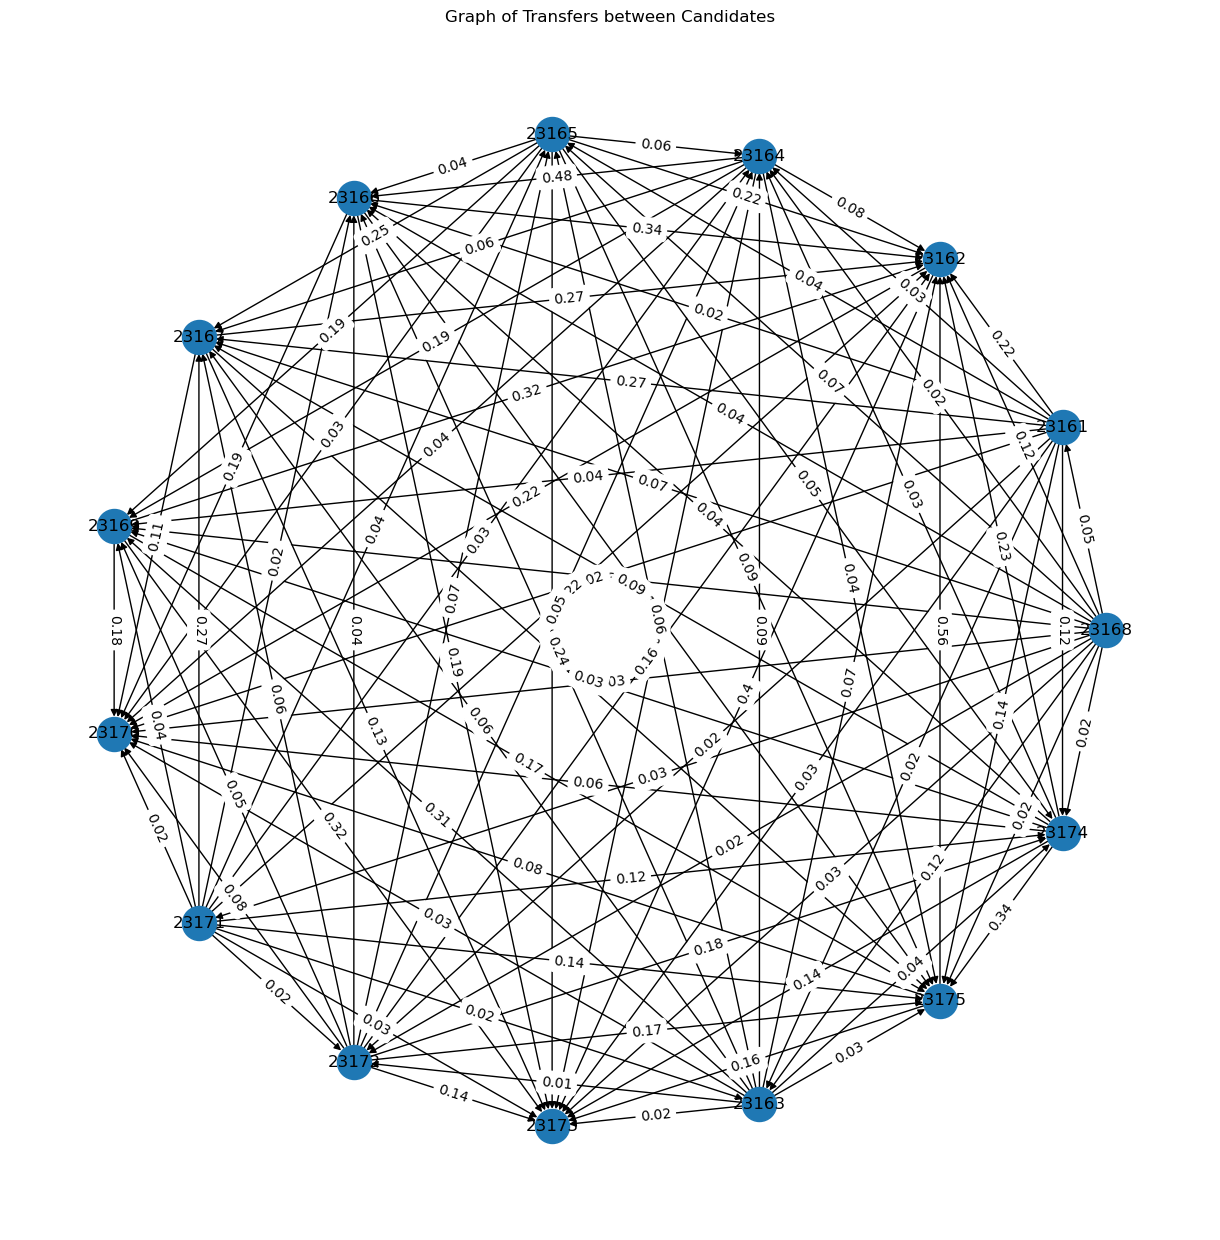

In [15]:
G0 = graph_of_data(constituency_df)
plot_G(G0)

#### relabel with candidate names and party abbrev by unique cand ID to name dictionary

In [16]:

full_df["label"] = (
    full_df["Candidate First Name"].astype(str) + " " +
    full_df["Candidate surname"].astype(str) + " " +
    full_df["Party Abbreviation"].astype(str)
)

In [17]:
#### function to 

In [18]:
def relabel_graph(G,df=full_df):
    df = df.copy() #copy for manip

    # replace Excel smart apostrophe
    def normalize_text(s):
        return (s.replace("\x92", "'"))

    df["label"] = (
        df["label"]
        .astype(str)
        .str.strip() #remove whitespace at ends
        .map(normalize_text)
    )

    #filter entire dataframe because all candidates' ids and labels are represented a single time in the first count
    dedup = (
        df[df["Count Number"] == 1]
          .drop_duplicates(subset=["Unique Candidate Id"], keep="first")
    )
    #build dict with keys as the unique id, and new labels as values
    label_lookup = dedup.set_index("Unique Candidate Id")["label"].to_dict()

    label_lookup
    new_labels = {cid: label_lookup.get(cid) for cid in G.nodes()}
    
    
    G_relabelled=nx.relabel_nodes(G,new_labels)
    
    return G_relabelled

In [19]:
G=relabel_graph(G0)

#### New graph with names as node labels

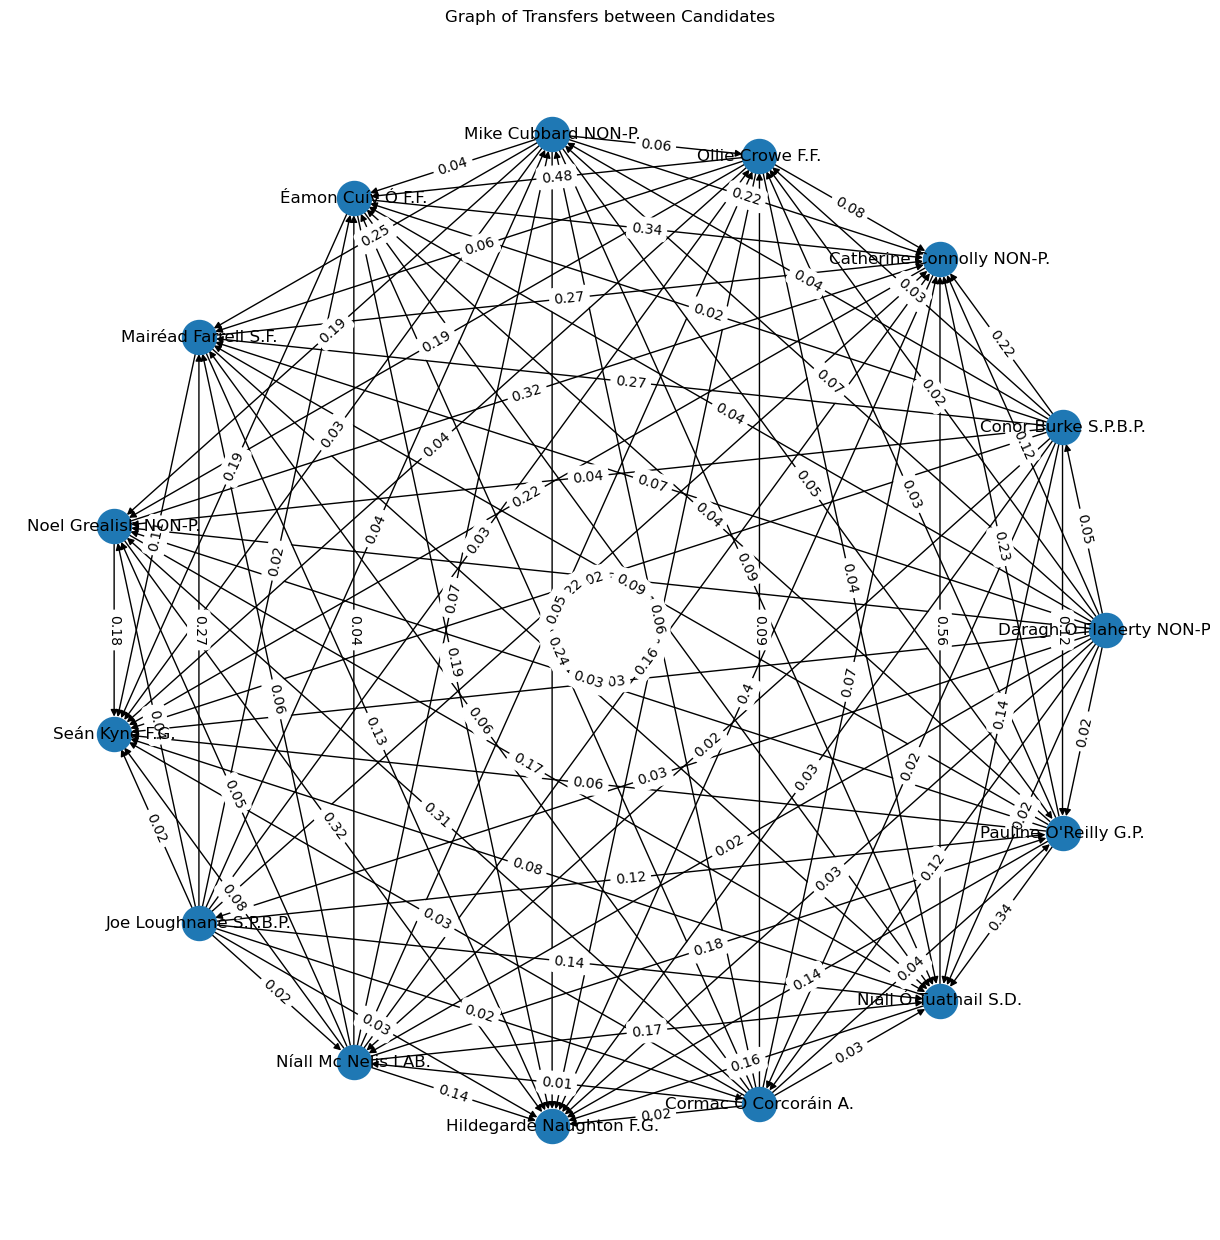

In [20]:
plot_G(G)

### Plot with weighted edges

In [21]:
plt.figure(figsize=(12, 10))
#pos = nx.nx_agraph.graphviz_layout(G, prog="sfdp") # good for labelled data
#label_pos = {n: (x, y-0.04) for n, (x, y) in pos.items()}
weights = nx.get_edge_attributes(G, 'weight')
min_w, max_w = 0.25, 8.0
edge_widths = [min_w + w*(max_w - min_w) for (_, _), w in weights.items()]
# nx.draw_networkx_nodes(G, pos, node_size=200)
# nx.draw_networkx_edges(G, pos, width=edge_widths);
# nx.draw_networkx_labels(
#     G, label_pos,
#     font_size=10,
#     horizontalalignment='center'
# );

<Figure size 1200x1000 with 0 Axes>

## Community detection

In [22]:
communities = nx.community.louvain_communities(G) #set seed for deterministic communities.
print(f"Communities produced by Louvain algorithm for {constituency}:\n")
for c in communities:
    print(f"{c}\n")
    
modularity = nx.community.modularity(G, communities)
print(f"Constituency: {constituency} has modularity {modularity:.4}")

Communities produced by Louvain algorithm for Galway West:

{'Éamon Cuív Ó F.F.', 'Ollie Crowe F.F.'}

{'Mike Cubbard NON-P.', 'Mairéad Farrell S.F.', 'Conor Burke S.P.B.P.', 'Joe Loughnane S.P.B.P.'}

{'Noel Grealish NON-P.', 'Cormac Ó Corcoráin A.', 'Daragh O Flaherty NON-P.'}

{'Hildegarde Naughton F.G.', 'Seán Kyne F.G.', 'Catherine Connolly NON-P.', 'Niall Ó Tuathail S.D.'}

{"Pauline O'Reilly G.P.", 'Níall Mc Nelis LAB.'}

Constituency: Galway West has modularity 0.1513


### Plot with colours indicating communities

In [23]:
community_colours = ["cyan", "yellow", "pink", "orange", "lightgrey", "green"]
nodes = list(G.nodes())
node_colors = []

for n in nodes:
    for i, comm in enumerate(communities):
        if n in comm:
            node_colors.append(community_colours[i])
            break

In [24]:
#nx.draw(G, pos, node_color=node_colors, with_labels=True, node_size=800, width=edge_widths)

In [25]:


comm_id = {}
for i, comm in enumerate(communities):
    for n in comm:
        comm_id[n] = i

# 2) Build a contracted "community graph" (super-graph)
H = nx.Graph()
H.add_nodes_from(range(len(communities)))  # one node per community

# Add weighted edges between communities based on total inter-community edge weight
for u, v, d in G.edges(data=True):
    cu, cv = comm_id[u], comm_id[v]
    if cu != cv:
        w = d.get('weight', 1.0)
        if H.has_edge(cu, cv):
            H[cu][cv]['weight'] += w
        else:
            H.add_edge(cu, cv, weight=w)

# 3) Lay out community centroids (use a force-directed layout on H)
centroid_pos = nx.circular_layout(H, scale=0.5)  # good spacing for small graphs
#centroid_pos = nx.nx_agraph.graphviz_layout(G, prog="sfdp")

# 4) Lay out nodes within each community around its centroid
pos = {}
for i, comm in enumerate(communities):
    # local layout for the community subgraph
    subG = G.subgraph(comm)
    local = nx.circular_layout(subG)  # compact local layout

    # translate local positions to the community centroid
    cx, cy = centroid_pos[i]
    # scale to keep the community tight; tweak 'scale' if you want bigger clusters
    scale = 0.25
    for n, (x, y) in local.items():
        pos[n] = (cx + scale * x, cy + scale * y)

In [26]:
labels = {n: wrap_label(str(n), width=9) for n in G.nodes}
print(labels)

{'Daragh O Flaherty NON-P.': 'Daragh O\nFlaherty\nNON-P.', 'Conor Burke S.P.B.P.': 'Conor\nBurke\nS.P.B.P.', 'Catherine Connolly NON-P.': 'Catherine\nConnolly\nNON-P.', 'Ollie Crowe F.F.': 'Ollie\nCrowe\nF.F.', 'Mike Cubbard NON-P.': 'Mike\nCubbard\nNON-P.', 'Éamon Cuív Ó F.F.': 'Éamon\nCuív Ó\nF.F.', 'Mairéad Farrell S.F.': 'Mairéad\nFarrell\nS.F.', 'Noel Grealish NON-P.': 'Noel\nGrealish\nNON-P.', 'Seán Kyne F.G.': 'Seán Kyne\nF.G.', 'Joe Loughnane S.P.B.P.': 'Joe\nLoughnane\nS.P.B.P.', 'Níall Mc Nelis LAB.': 'Níall Mc\nNelis\nLAB.', 'Hildegarde Naughton F.G.': 'Hildegarde\nNaughton\nF.G.', 'Cormac Ó Corcoráin A.': 'Cormac Ó\nCorcoráin\nA.', 'Niall Ó Tuathail S.D.': 'Niall Ó\nTuathail\nS.D.', "Pauline O'Reilly G.P.": "Pauline\nO'Reilly\nG.P."}


Writing to Galway-West-GE2020.png


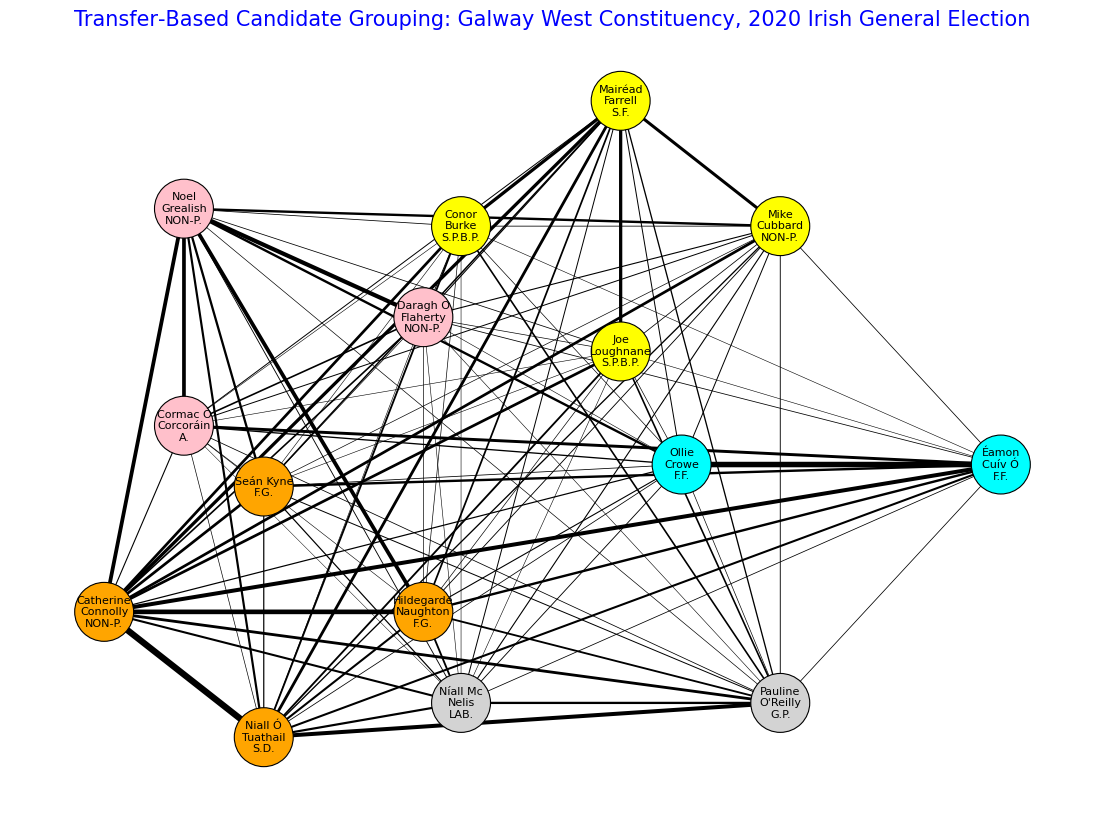

In [27]:
plt.figure(figsize=(14, 10))
nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=1800, edgecolors='k', linewidths=0.8)
nx.draw_networkx_edges(G, pos, width=edge_widths)
nx.draw_networkx_labels(G, pos, font_family="DejaVu Sans", font_size=8, labels=labels)
plt.axis('off')
#plt.tight_layout()
FileName = f"{constituency.replace(' ', '-')}-GE{Year}.png"
print(f"Writing to {FileName}")
plt.title(f"Transfer‑Based Candidate Grouping: {constituency} Constituency, {Year} Irish General Election",
         fontsize=15,
         color="blue")
plt.savefig(FileName, dpi=300, bbox_inches='tight')
plt.show()

## Build a dictionary of constituencise and their modularities

In [28]:
modularity_dict={"Constituency":[],
                 
                 "Modularity":[]}

In [29]:
for c in constituency_list:
    
    constituency_df = full_df[full_df["Constituency Name"]==c]
    
    G0 = graph_of_data(constituency_df)
    
    G = relabel_graph(G0, constituency_df)
    communities = nx.community.louvain_communities(G, seed=12)
    m = nx.community.modularity(G, communities)
    
    modularity_dict["Constituency"].append(c)
    modularity_dict["Modularity"].append(round(m,3))

In [30]:
# modularity_dict

In [31]:
modularity_df=pd.DataFrame.from_dict(modularity_dict)

In [32]:
modularity_df=modularity_df.sort_values(by="Modularity",ascending=False)

In [33]:
# modularity_df.to_csv("modularity2020.csv",index=False)